# Simulating the Harber Bosch process with quantum computing

## To ask
Partial requires grad

## Progress

- [x] Hamiltonian `H_1` for all components
- [ ] Reduce number of terms for `H_1`
- [ ] LCU to simulate `H_1`

# ! Steps

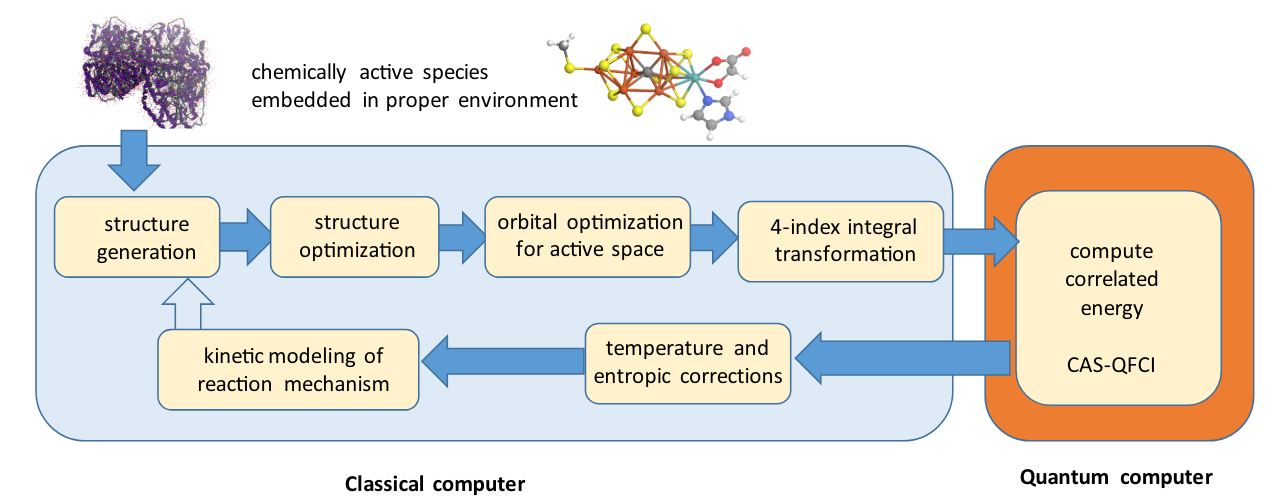                                                                                                                                 

| C/Q | Steps according to the paper | Comments |
|---|---|---|
| C | Choose structural model of the active chemical species |  |
| C | Set up and optimize structures of potential intermediates | These calculations were performed using Quantum Espresso, perhaps we can do https://pennylane.ai/qml/demos/tutorial_mol_geo_opt/  |
| C | Molecular orbitals are then optimized for a suitably chosen Fock operator. |   |
| C | A four-index transformation from the atomic orbital to the molecular basis produces all integrals required for the second-quantized Hamiltonian | That is the ultimate goal of the above steps, but can we skip all of them just because we can generate a good enough Hamiltonian? |
| Q | Calculate the ground state energy of the Hamiltonian |  |
| C | Correct the energy by considering nuclear motion effects to yield enthalpic and entropic quantities at a given temperature according to DFT |  |
| C | The temperature-corrected energy differences between stable intermediates and transition structures then enter rate expressions for kinetic modeling | |

## Structure generation

In[1]:

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

In [2]:
from ase import Atoms
from ase.visualize import view
from pyscf import gto, scf, ci
from pennylane.qchem import import_state

In [3]:
from tqdm import tqdm

In [4]:
import time

According to [Fig 1. in this paper](https://pubs.rsc.org/en/content/getauthorversionpdf/c9cp01611b), the config of $Fe$ latice is

> Fe coordinate
> - the top site corresponds to (1.0, 0.0, 0.50)
> - the bottom site corresponds to (0.69, 0.14, 0.36)
> - the climbing site corresponds to (0.63, 0.58, 0.44)
> - the bridge site corresponds to (0.7, 1.0, 0.44)
> - the trough site corresponds to (0.59, 0.50, 0.31)
> 
> Binding preference location
> - H prefers the bridge (0.71 eV) and top sites (0.62-0.70eV),
> - N prefers the bottom sites (1.06 eV) and the trough sites (1.53 eV),
> - NH prefers the bottom site with the H opposite the first layer Fe atoms to minimize vdW repulsion (0.92 eV),
> - NH2 prefers the climbing site (0.70 eV), and
> - NH3 prefers the top site (0.49 eV)

Always 4 $N$ in Fig 3

In[2]:

In [5]:
from rdkit.Chem import rdmolfiles, SDMolSupplier, rdmolfiles
sd_supplier = SDMolSupplier("Structure2D_COMPOUND_CID_123329.sdf")

In[3]:

In [6]:
for mol in sd_supplier:
    print(rdmolfiles.MolToXYZBlock(mol))

1
123329
N      2.536900   -0.155000    0.000000



In[4]:

In [7]:
np.random.seed(17)

In[5]:

In [8]:
n2_x = np.random.uniform(0,1.1,[2])    # one value for N2

In [9]:
h2_x = np.random.uniform(0,1.1,[6])    # three values for H2
h2_y = np.random.uniform(-0.1,1.1,[6])
h2_z = np.random.uniform(0.2,0.6,[6])

In[6]:

In [10]:
# 3N_NH2. NH2 is a radical, short lived https://pubchem.ncbi.nlm.nih.gov/compound/123329#section=2D-Structure
nh2_n = [2.5369, -0.1550, 0.0000]    
nh2_h1 = [3.0739,    0.1550,    0.0000]
nh2_h2 = [2.0000,    0.1550,    0.0000]

In[7]:

In [11]:
fe_top = [1.0, 0.0, 0.50]
fe_bottom = [0.69, 0.14, 0.36]
fe_climbing = [0.63, 0.58, 0.44]
fe_bridge = [0.7, 1.0, 0.44]
fe_trough = [0.59, 0.5, 0.31]

Let's visualize!

In[8]:

In [12]:
#fe_latice = Atoms('FeFeFeFeFe', [fe_top, fe_bottom, fe_climbing, fe_bridge, fe_trough])
fe_latice = Atoms('FeFeFeFeFeNHH', [fe_top, fe_bottom, fe_climbing, fe_bridge, fe_trough, nh2_n, nh2_h1, nh2_h2])
view(fe_latice, viewer='ngl')

## ! New define Hamitonian

Fe:
- $4s2:\uparrow \downarrow$
- $3d6:\uparrow \downarrow,\uparrow,\uparrow,\uparrow,\uparrow $

Therefore there are four active oribitals

> Defining a chemically meaningful active space depends on the problem and usually requires some experience.
[Source](https://discuss.pennylane.ai/t/co2-active-electrons-orbitals/1589/2)

In[9]:

In [13]:
# NH2 and Fe
# N: 1s2 2s2 2p3
electrons = 1 + 1 + 7         # H + H + N
orbitals = 1 + 1 + 1 + 1 + 3  # (1s1) + (1s1) + (1s2 + 2s2 + 2p3)
active_electrons = 1 + 1 + 3  # (1s1) + (1s1) + (2p3)
active_orbitals = 1 + 1 + 3   # (1s1) + (1s1) + (2p3)

In[10]:

In [14]:
def hamiltonian_from_coords(coords):
    symbols = ["Fe","Fe","Fe","Fe","Fe", "N", "H", "H"]
    base_coords = fe_top + fe_bottom + fe_climbing + fe_bridge + fe_trough
    coordinates = np.append(base_coords, coords)      # qml/autograd numpy doesn't support append
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf',
                                            active_electrons=active_electrons,
                                            active_orbitals=active_orbitals, 
                                            mult=1+1) # one unpaired e
    return H, qubits

### Geometry optimization

I am planning to use a pure quantum method rather than the classical way.
- Build the parametrized electronic Hamiltonian H(x) of the molecule.
- Design the variational quantum circuit to prepare the electronic trial state $|\Psi(\theta)⟩$
- Define the cost function $⟨\Psi(\theta)|H|\Psi(\theta)⟩$
- Optimize for $\theta$

#### Create circuit

In [15]:
def circuit(H, params, hf_state, singles, doubles):
    qml.AllSinglesDoubles(hf_state=hf_state, weights=params, 
                         wires=H.wires,
                         singles=singles,
                         doubles=doubles)
    return qml.expval(H)

## Some manual grad calculation

In [16]:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

In [17]:
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function
    x: coordinates, thetas is the rotational angles
    """
    gradient = []
    n_qubits, singles, doubles = [], [], []
    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        right_shift = f(x + shift)
        left_shift = f(x - shift)
        res = (right_shift[0] - left_shift[0]) * delta**-1  # [0] because it corresponds to the Hamiltonian
        gradient.append(res)
        # appending auxiliary params
        assert right_shift[1] == left_shift[1]  # equals number of qubits
        assert right_shift[2] == left_shift[2]  # equals number of single gates
        assert right_shift[3] == left_shift[3]  # equals number of double gates
        n_qubits.append(right_shift[1])
        singles.append(right_shift[2])
        doubles.append(right_shift[3])

    return gradient, (n_qubits, singles, doubles)

In [18]:
def grad_x(params, x):
    # variational for each shift in each coordinate and see how the coordinates changes
    grad_h, auxiliary = finite_diff(prepare_H, x)
    n_qubits, singles, doubles = auxiliary
    hf_states = [qchem.hf_state(active_electrons, n_qubit) for n_qubit in n_qubits]
    start = time.time()
    grad = []
    for i, obs in enumerate(grad_h):
        dev = qml.device("lightning.qubit", obs.wires)
        qnode = qml.QNode(circuit, dev)
        grad.append(qnode(obs, params, hf_states[i], singles[i], doubles[i]))
    print(f"Calculating grad_x takes {time.time() - start} seconds, {grad}")
    return np.array(grad)

In [19]:
def prepare_H(coords):
    H, qubits = hamiltonian_from_coords(coords)
    n_qubits = len(H.wires)
    singles, doubles = qchem.excitations(active_electrons, n_qubits)
    return H, n_qubits, singles, doubles

In [20]:
def loss_f(thetas, coords):
    H, n_qubits, singles, doubles = prepare_H(coords)
    hf_state = qchem.hf_state(active_electrons, n_qubits)
    dev = qml.device("lightning.qubit", n_qubits)
    qnode = qml.QNode(circuit, dev)
    return qnode(H, thetas, hf_state, singles, doubles)

#### Optimize 

In [21]:
def optimize():
    # prepare for the 1st run
    nh2_coords = np.array(nh2_n + nh2_h1 + nh2_h2)    
    total_single_double_gates = 54
    
    # store the values of the cost function
    thetas = np.random.normal(0, np.pi, total_single_double_gates)
    max_iterations = 100

    # store the values of the circuit parameter
    angle = []
    coords = []

    for _ in tqdm(range(max_iterations)):
        # Optimize the circuit parameters
        thetas.requires_grad = True
        nh2_coords.requires_grad = False
        start = time.time()
        thetas, _ = opt_theta.step(loss_f, thetas, nh2_coords)
        print(f"{time.time()-start} seconds")
        # Optimize the nuclear coordinates
        nh2_coords.requires_grad = True
        thetas.requires_grad = False
        _, nh2_coords = opt_x.step(loss_f, thetas, nh2_coords, grad_fn=grad_x)
        """
        loop for coordinate 9 coord
           shift coordinate
           Hamotonian
           optmize for theta for that H 
        """
        
        angle.append(thetas)
        coords.append(nh2_coords)
        
    return angle, coords

In [ ]:
angles, coords = optimize()

  0%|                                                                                                                                                     | 0/100 [00:00<?, ?it/s]

105.1817090511322 seconds


## Next step / meeting minute

### 2nd week
The quantity we need to measure
- The intermidiate configurations
    - N2 bonds with Fe -> get the Hamiltonian
    - H2 bond with Fe -> get the Hamiltonian
    - N2 -> 2 N -> get the Hamiltonian
    - H2 -> 2H -> get the Hamiltonian 
    - H+N -> NH3 -> get the Hamiltonian
- Active method https://arxiv.org/pdf/2404.18737 
- https://pubs.acs.org/doi/10.1021/acs.jpca.8b10007
- https://pubs.rsc.org/en/content/getauthorversionpdf/c9cp01611b Reaction pathway

### 1st week
1. Use params `active_electrons`, `active_orbitals` inside `molecular_hamiltonian`
    1. Principled way to do it without knowing Fe is catalyst?
       > valence electron in the outer shell, choose the radius (coordinate?)
    2. Coordinates
       > coordinate for reactant, coordinate for products may be in somewhere else
       > evaluate energy at a lot of different coordinates?
       > Put H2 N2 Fe closer and then farther to see what happens. There must be a method
    3. QPE
       > Time evolution. Trotter, LCU (build different matrix, one of them is time evolution), Qubitizations
2. ZNE?
    1. If it concat a chain of gates, could the real system reach the end of the gates?
    2. Doesn't seem to need more qubit?
3. Paper
   1. https://www.pnas.org/doi/abs/10.1073/pnas.1619152114
   2. https://arxiv.org/pdf/2007.14460